<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/Models_v3/VAE_Novel_NASA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
import pandas as pd
from sklearn.metrics import roc_curve, auc
tf.autograph.set_verbosity(0)
from google.colab import drive
drive.mount('/content/drive/')

TensorFlow 2.x selected.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### Import Data and plot it

In [0]:
def plot_images(data, image_to_plot):
    plot = plt.figure(figsize=[15,2])
    for i in range(img_channels):
        plt.subplot(1, img_channels, i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(data[image_to_plot][:,:,i], cmap=plt.cm.binary)
    plt.show()

#### Select data, pre-process it and create dataset

In [0]:
def set_pixels_binary(images):
    images = images/input_range
    images[images >= 0.5] = 1.0
    images[images < 0.5] = 0.0
    return images

def setup_dataset(x):
  images = set_pixels_binary(x)

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x_train, x_test):
  train_images = set_pixels_binary(x_train)
  test_images = set_pixels_binary(x_test)

  batch_size = 100
  train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).batch(batch_size)
  return train_dataset, test_dataset

#### Create Variational Autoencoder (VAE) Model

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([ 
                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 6)),
                          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(units=60*60*64, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(60, 60, 64)),
                          tf.keras.layers.Conv2DTranspose(32, (3,3), activation='relu'),
                          tf.keras.layers.Conv2DTranspose(6, (3,3)),
                          ])

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled    

    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        pixel_mean = tf.math.sigmoid(pixel_output)
        return pixel_mean

#### Define the loss function 

In [0]:
def calculate_KL(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    KL = tf.reduce_mean(KL_vectors)
    return KL

def calculate_logpx_z(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_prob = model.decode(z)
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    return logpx_z

def calculate_ELBO(model, x):
    logpx_z = calculate_logpx_z(model, x)
    KL = calculate_KL(model, x)
    
    ELBO = logpx_z - KL 
    return -ELBO #Negative because we want to maximise it

#### Define the optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)

#### Define loss metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

#### Define train and test steps

In [0]:
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, optimizer):
    loss = calculate_ELBO(model, x)
    test_loss(loss)

In [0]:
def train_test_dataset(model, train_dataset, test_dataset, epochs):
  test_ELBO = []
  train_ELBO = []
  epoch_number = []  
  for epoch in range(epochs):
    print('Performing Epoch {}'.format(epoch))
    for train_x in train_dataset: 
      train_step(model, train_x, optimizer)
  
    for test_x in test_dataset:
      test_step(model, test_x, optimizer)
    
    test_ELBO.append(-test_loss.result())
    train_ELBO.append(-train_loss.result())
    epoch_number.append(epoch)
    
    clear_output()
    plt.plot(epoch_number, test_ELBO, train_ELBO)
    plt.legend(['test','train'])
    plt.title('model')
    plt.show()
  train_loss.reset_states()
  test_loss.reset_states()

In [0]:
def train_only_dataset(model, train_dataset, epochs):
  train_ELBO = []
  epoch_number = []  
  for epoch in range(epochs):
    for train_x in train_dataset: 
      train_step(model, train_x, optimizer)

    loss = train_loss.result()
    train_ELBO.append(-loss)
    epoch_number.append(epoch)
     
  train_loss.reset_states()
  test_loss.reset_states()
  return loss

#### Train the data

In [0]:
typical_images = np.load('/content/drive/My Drive/SPACE_DATA/typical_images.npy')
novel_images = np.load('/content/drive/My Drive/SPACE_DATA/novel_images.npy')

N_typical_images = typical_images.shape[0]
N_novel_images = novel_images.shape[0]
img_height = typical_images.shape[1]
img_width = typical_images.shape[2]
img_channels = typical_images.shape[3]
input_range = np.amax(typical_images)

In [0]:
z_size = 2
model = CVAE(z_size)

4.19---> 6363.455


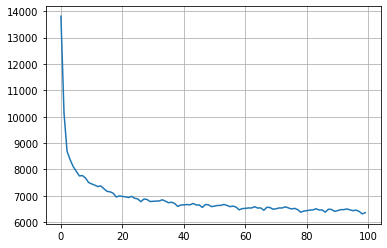

540.6228933334351


In [35]:
start_time = time.time()
losses = []
for j in range(5):
  for i in range(20):
    if i != 19: num = 5000
    if i == 19: num = 3700
    train_dataset = setup_dataset(typical_images[i*5000:i*5000+num].astype('float32'))
    loss = train_only_dataset(model, train_dataset, 1)
    losses = np.append(losses, loss.numpy())
    
    clear_output()
    print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))
    plt.plot(range(len(losses)), losses)
    plt.grid(which='both', axis='both')
    plt.show()
print(time.time()-start_time)

In [0]:
#model.encoder_nn.save_weights('/content/drive/My Drive/4YP/Saved_NASA_model/CVAE_Encoder_25/Encoder.npy')
#model.decoder_nn.save_weights('/content/drive/My Drive/4YP/Saved_NASA_model/CVAE_Decoder_25/Decoder.npy')
#model.encoder_nn.save_weights('/content/drive/My Drive/4YP/Saved_NASA_model/CVAE_Encoder_10/Encoder.npy')
#model.decoder_nn.save_weights('/content/drive/My Drive/4YP/Saved_NASA_model/CVAE_Decoder_10/Decoder.npy')
#model.encoder_nn.save_weights('/content/drive/My Drive/4YP/Saved_NASA_model/CVAE_Encoder_2/Encoder.npy')
#model.decoder_nn.save_weights('/content/drive/My Drive/4YP/Saved_NASA_model/CVAE_Decoder_2/Decoder.npy')

In [37]:
CVAE_25 = CVAE(25)
CVAE_25.encoder_nn.load_weights('/content/drive/My Drive/4YP/Saved_NASA_model/CVAE_Encoder_25/Encoder.npy')
CVAE_25.decoder_nn.load_weights('/content/drive/My Drive/4YP/Saved_NASA_model/CVAE_Decoder_25/Decoder.npy')
CVAE_10 = CVAE(10)
CVAE_10.encoder_nn.load_weights('/content/drive/My Drive/4YP/Saved_NASA_model/CVAE_Encoder_10/Encoder.npy')
CVAE_10.decoder_nn.load_weights('/content/drive/My Drive/4YP/Saved_NASA_model/CVAE_Decoder_10/Decoder.npy')
CVAE_2 = CVAE(2)
CVAE_2.encoder_nn.load_weights('/content/drive/My Drive/4YP/Saved_NASA_model/CVAE_Encoder_2/Encoder.npy')
CVAE_2.decoder_nn.load_weights('/content/drive/My Drive/4YP/Saved_NASA_model/CVAE_Decoder_2/Decoder.npy')

(1, 64, 64, 6)
Original Pictures:


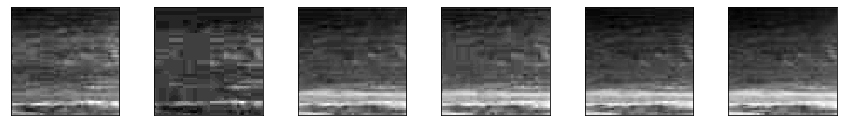

Reconstructed Pictures, with ELBO loss:


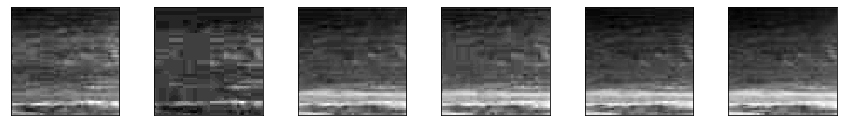

[2692.]


In [47]:
def reconstruct_images(model, data, images):
    images_n = 1
    x = data[images]/input_range
    x[x >= 0.5] = 1.0
    x[x < 0.5] = 0.0
    x = x.reshape(images_n, img_height, img_width, img_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    print(np.shape(pixel_prob))

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i] = calculate_ELBO(model,x[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(data, images)
    print('Reconstructed Pictures, with ELBO loss:')
    plot_images(data, images)
    return loss

loss = reconstruct_images(CVAE_2, typical_images, 0)
print(loss)

In [0]:
# 1941-1968
# 2100-2144
# 2972-3000
# 3896-3936

#### Visualize the latent space

0 Outliers detected
309.7913155555725


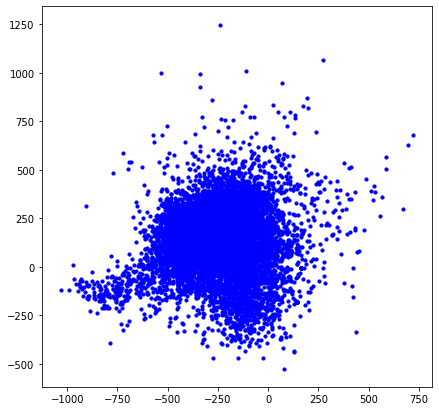

In [53]:
def visualize_latent_space(model, range1, range2, data_x, a, b):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  outlier = []
  latent_space = np.zeros([2, range2-range1, 25])
  for i in range(range1, range2):
    pic_visualize = data_x[i]
    pic_visualize = pic_visualize.reshape(1, img_height, img_width, img_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(pic_visualize)
    z = model.reparameterize(z_mean, z_logvar)
    latent_space[0,i,:] = z_mean
    latent_space[1,i,:] = z_logvar
    
    if any(z_logvar[:,i]>10 for i in range(model.z_size)):
      outliers +=1
      outlier.append(i)
      continue

    #color_dict = dict([(0,'blue'), (1,'orange'), (2,'green'), (3,'red'), (4,'purple'), (5,'brown'), (6,'pink'), (7,'gray'), (8,'black'), (9,'yellow')])
    plt.scatter(z[:,a],z[:,b], color = 'blue', s=10)

  print('{} Outliers detected'.format(outliers))
  return latent_space, outlier

start_time = time.time()
latent_space, outlier = visualize_latent_space(CVAE_25, 0, 10000, typical_images, 0,1)
print(time.time()-start_time)

In [0]:
print(np.shape(latent_space))
np.save('/content/drive/My Drive/4YP/latent_space_nov.npy',latent_space)

#### Check reconstruction performance for untrained classes and create table of losses


In [0]:
table_of_losses = np.zeros([N_class, 5])
for i in range(1):
  model = model_nov_10
  #print('Model trained with class {}'.format(i))
  plt.figure(1, figsize=[9,4])
  plt.figure(2, figsize=[9,4])
  plt.figure(3, figsize=[9,4])
  plt.figure(4, figsize=[9,4])
  plt.figure(5, figsize=[9,4])
  for j in range(N_class):
    test_images = x_train[(y_train==j)]
    test_images = set_pixels_binary(test_images)
    test_images = test_images.reshape(len(test_images), image_shape[0], image_shape[1], N_image_channels).astype('float32')
    ELBO_loss = calculate_ELBO(model, test_images)
    logpx_z_loss = calculate_logpx_z_mean(model, test_images)
    KL_loss = calculate_KL(model, test_images)
    pixel_squared_loss = calculate_pixel_squared(model,test_images)
    #print(pixel_squared_loss)
    #ssim_loss = calculate_ssim(model, test_images)
    #ssim_loss = np.mean(ssim_loss)
    #print(ssim_loss)
    table_of_losses[j,0] = ELBO_loss
    table_of_losses[j,1] = -logpx_z_loss
    table_of_losses[j,2] = KL_loss
    table_of_losses[j,3] = pixel_squared_loss
    #table_of_losses[j,4] = ssim_loss
    if j==8 or j==9:
      color='red'
    else:
      color='blue'
    plt.figure(1)
    plt.bar(j,ELBO_loss.numpy(),color=color)
    plt.figure(2)
    plt.bar(j,-logpx_z_loss.numpy(),color=color)
    plt.figure(3)
    plt.bar(j,KL_loss.numpy(),color=color)
    plt.figure(4)
    plt.bar(j,pixel_squared_loss.numpy(),color=color)
    #plt.figure(5)
    #plt.bar(j,ssim_loss.numpy(),color=color)

#for i in range(N_class):
#    table_of_losses[i,:] = table_of_losses[i,:]/np.min(table_of_losses[i,:])
 
index = list(str('-') * N_class)
columns = list(str('-') * (N_class))
for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = 'Model ' + str(i)

table_loss = pd.DataFrame.from_records(np.around(np.transpose(table_of_losses), decimals=2), index=['ELBO', 'Recon_likelihood', 'KL_divergence', 'Recon_error', 'SSIM'])
table_loss


### Predict Novelties with threshold

##### Calculate novelty scores

Loss_1 = Deterministic reconstruction error

Loss_2 = Encoder-stochastic reconstruction error average

Loss_3 = Encoder-stochastic reconstruction error minimum

Loss_4 = Deterministic reconstruction likelihood

Loss_5 = Encoder-stochastic reconstruction likelihood average

Loss_6 = Encoder-stochastic reconstruction likelihood minimum

Loss_7 = Fully deterministic distance-based reconstruction error

Loss_8 = Test deterministic distance-based reconstruction error

Loss_9 = Train deterministic distance-based reconstruction error

Loss_10 = Bhattacharyya distance of deterministic reconstruction likelihood

Loss_11 = ELBO

Loss_12 = ELBO average

Loss_13 = ELBO minimum

Loss_14 = KL Divergence

Loss_15 = Euclidean distance between means of the distributions

Loss_16 = Bhattacharyya distance between distributions

Loss_17 = Density latent space 

In [0]:
def Loss_1(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_squared = np.square(pixel_prob - images)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, pixel_squared)
  return losses_per_image

def Loss_2(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_3(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_4(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
    logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    losses_per_image = np.append(losses_per_image, logpx_z_images)
  return losses_per_image

def Loss_5(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
      logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
      avg[j,:] = logpx_z_images
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_6(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
      logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
      avg[j,:] = logpx_z_images
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_7(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_7:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_8(model, x_train, x_test):
  losses_per_image = []
  image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    if a != 0: image_train = np.append(image_train, images, axis=0)
    else: image_train = images; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_9:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_9(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: image_test = np.append(image_test, images, axis=0)
    else: image_test = images; b = 1  
  num = len(image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_10:{}%'.format(100*(i)/num))
    temporary = np.abs(image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_10(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_8:{}%'.format(100*(i)/num))
    temporary = np.sqrt(np.multiply(1-pixel_prob_per_image_test[i],np.subtract(1,pixel_prob_per_image_train)))+np.sqrt(np.multiply(pixel_prob_per_image_test[i],pixel_prob_per_image_train))
    temporary = np.log(temporary)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_11(model, x):
  losses_per_image = Loss_4(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_12(model, x):
  losses_per_image = Loss_5(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_13(model, x):
  losses_per_image = Loss_6(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_14(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    losses_per_image = np.append(losses_per_image, KL_vectors)
  return losses_per_image

def Loss_15(model, x_train, x_test):
  losses_per_image = []
  z_mean_per_image_train = []
  z_mean_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: z_mean_per_image_train = np.append(z_mean_per_image_train, z_mean, axis=0)
    else: z_mean_per_image_train = z_mean; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_per_image_test = np.append(z_mean_per_image_test, z_mean, axis=0)
    else: z_mean_per_image_test = z_mean; b = 1 
  num = len(z_mean_per_image_test)
  for i in range(num):
    if not i%500: clear_output(); print('Progress Loss_15:{}%'.format(100*(i)/num))
    temporary = np.abs(z_mean_per_image_test[i] - z_mean_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=1)
    losses_per_image = np.append(losses_per_image, np.min(temporary)) 
  return losses_per_image

def Loss_16(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []; z_var_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: 
      z_mean_test = np.append(z_mean_test, z_mean, axis=0)
      z_var_test = np.append(z_var_test, np.exp(z_logvar), axis=0)
    else: 
      z_mean_test = z_mean
      z_var_test = np.exp(z_logvar)
      b = 1 
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_16:{}%'.format(100*(i)/num))
    temporary_1 = np.log(np.multiply(0.25, (np.add(np.divide(z_var_test[i], z_var_train), np.add(np.divide(z_var_train, z_var_test[i]),2)))))
    temporary_2 = np.divide(np.square(np.subtract(z_mean_test[i], z_mean_train)), np.add(z_var_test[i], z_var_train))
    temporary = np.multiply(0.25, temporary_1) + np.multiply(0.25, temporary_2)
    losses_per_image = np.append(losses_per_image, np.min(np.sum(temporary)))
  return losses_per_image

def Loss_17(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_test = np.append(z_mean_test, z_mean, axis=0)
    else: z_mean_test = z_mean; b = 1 
  
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_17:{}%'.format(100*(i)/num))
    A = np.divide(0.39894, np.sqrt(z_var_train))
    B1 = np.subtract(z_mean_test[i], z_mean_train)
    B2 = np.sqrt(z_var_train)
    B = np.multiply(-0.5, np.square(np.divide(B1,B2)))
    temporary = np.multiply(A, np.exp(B))
    temporary = np.mean(temporary)
    losses_per_image = np.append(losses_per_image, temporary) 
  return -losses_per_image

In [0]:
Loss_functions_dict = dict([(1,Loss_1),(2,Loss_2),(3,Loss_3),(4,Loss_4),(5,Loss_5),(6,Loss_6),(7,Loss_7),
                            (8,Loss_8),(9,Loss_9),(10,Loss_10),(11,Loss_11),(12,Loss_12),(13,Loss_13),
                            (14,Loss_14),(15,Loss_15),(16,Loss_16),(17,Loss_17)])

In [93]:
losses_typical = dict([])
losses_novel = dict([])

for j in [1,2,3,4,5,6,11,12,13,14]:
  start_time = time.time()
  
  losses_typical[j] = []
  print('LOSS {} Pogress/20: '.format(j), end='')
  for i in range(20):
    print('{}, '.format(i+1), end='')
    if i != 19: num = 5000
    if i == 19: num = 3700
    dataset = setup_dataset(typical_images[i*5000:i*5000+num].astype('float32'))
    losses_typical[j] = np.append(losses_typical[j], Loss_functions_dict[j](CVAE_25, dataset))

  print('novel')
  dataset = setup_dataset(novel_images[0:300].astype('float32'))
  losses_novel[j] = Loss_functions_dict[j](CVAE_25, dataset)

  print('LOSS {} Time ---> {} sec \n'.format(j, time.time()-start_time))

LOSS 1 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 1 Time ---> 52.03641486167908 sec 

LOSS 2 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 2 Time ---> 789.0733709335327 sec 

LOSS 3 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 3 Time ---> 786.2788662910461 sec 

LOSS 4 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 4 Time ---> 46.4659218788147 sec 

LOSS 5 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 5 Time ---> 593.7231106758118 sec 

LOSS 6 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 6 Time ---> 591.379073381424 sec 

LOSS 11 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, novel
LOSS 11 Time ---> 67.69414949417114 sec 

LOSS 12 Pogress/20: 1, 2, 3, 4, 5, 6, 7, 

In [0]:
np.save('/content/drive/My Drive/4YP/Saved_NASA_model/losses_typical_dict.npy',losses_typical)
np.save('/content/drive/My Drive/4YP/Saved_NASA_model/losses_novel_dict.npy',losses_novel)

In [0]:
losses_typical_dict = np.load('/content/drive/My Drive/4YP/Saved_NASA_model/losses_typical_dict.npy', allow_pickle=True)
losses_typical_dict = losses_typical_dict.item()
losses_novel_dict = np.load('/content/drive/My Drive/4YP/Saved_NASA_model/losses_novel_dict.npy', allow_pickle=True)
losses_novel_dict = losses_novel_dict.item()

In [0]:
#losses_7_test = Loss_7(model_nov_25, train_dataset_nov, test_dataset_full)
#losses_8_test = Loss_8(model_nov_25, train_dataset_nov, test_dataset_full)
#losses_9_test = Loss_9(model_nov_25, train_dataset_nov, test_dataset_full)
#losses_10_test = Loss_10(model_nov_25, train_dataset_nov, test_dataset_full)
#losses_15_test = Loss_15(model_nov_25, train_dataset_nov, test_dataset_full)
#losses_16_test = Loss_16(model_nov_25, train_dataset_nov, test_dataset_full)
#losses_17_test = Loss_17(model_nov_25, train_dataset_nov, test_dataset_full)

### Train Classifier

In [184]:
losses_train = np.append(losses_novel_dict[1], losses_typical_dict[1])
y_train = np.zeros([len(losses_novel_dict[1])+len(losses_typical_dict[1]),])
y_train[98700:99000] = 1

{0: 0.5015197568389058, 1: 165.0}

In [0]:
classifier = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu', input_shape=(1,)),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

classifier.summary()

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))

classifier.fit(losses_train, y_train, batch_size=50, epochs=5, class_weight=class_weights, shuffle=True)
#classifier.fit(losses_train, y_train, batch_size=50, epochs=5, shuffle=True)
predictions = classifier.predict(losses_train)

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 129       
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
  ...
    to  
  ['...']
Train on 99000 samples
Epoch 1/5
99000/99000 [==============================] - 6s 64us/sample - loss: 7.3192 - binary_accuracy: 0.5031
Epoch 2/5
99000/99000 [==============================] - 6s 61us/sample - loss: 5.5883 - binary_accuracy: 0.5347
Epoch 3/5
99000/99000 [==============================] - 6s 61us/sample - loss: 5.9814 - binary_accuracy: 0.5192
Epoch 4/5
99000/99000 [==============================] - 6s 63us/sample - loss: 4.0512 - binary_accuracy: 0.5242
Epoch 5/5
99000/9

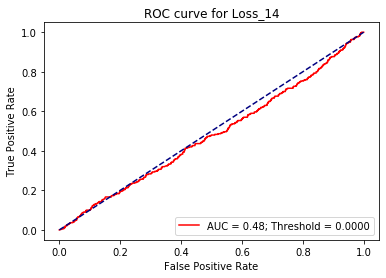

3.642538e-06
0.47859035798716654


In [199]:
threshold, auc = threshold_ROC(y_train, predictions, 'Loss_'+str(i), plot=True)
print(threshold)
print(auc)

#### Predict novelties

In [0]:
def threshold_ROC(y_true, y_score, title, plot=True):
  fpr, tpr, threshold = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
  optimal_threshold = threshold[optimal_idx]
  if plot:
    plot = plt.figure()
    plt.plot(fpr, tpr, color='red', label='AUC = %0.2f; Threshold = %0.4f' % (roc_auc,optimal_threshold))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + title)
    plt.legend(loc="lower right")
    plt.show()
  return optimal_threshold, roc_auc

#threshold_dict = dict([])
#auc_dict = dict([])
#for i in range(1,18):
#  threshold_dict[i], auc_dict[i] = threshold_ROC(y_true, losses_dict[i], 'Loss_'+str(i), plot=False)

In [0]:
def check_results(y, losses, threshold):
  novelty_y = np.zeros([len(y),])
  novelty_y[np.where(y >= 8)] = 1
  novelty_prediction = np.zeros([len(y),])
  novelty_prediction[np.where(losses>threshold)] = 1

  table_of_counts = np.zeros([2,2])
  for i in range(len(y),):
    if novelty_y[i] == 0:
      if novelty_prediction[i] == 0:
        table_of_counts[0,0] += 1
      else: table_of_counts[0,1] += 1
    if novelty_y[i] == 1:
      if novelty_prediction[i] == 0:
        table_of_counts[1,0] += 1
      else: table_of_counts[1,1] += 1

  true_positive = table_of_counts[1,1]
  false_positive = table_of_counts[0,1]
  true_negative = table_of_counts[0,0]
  false_negative = table_of_counts[1,0]

  accuracy = (true_positive+true_negative)/len(y)
  avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

  return table_of_counts, accuracy, avg_accuracy

table_of_counts_dict = dict([])
accuracy_dict = dict([])
avg_accuracy_dict = dict([])
for i in range(1,18):
  table_of_counts_dict[i], accuracy_dict[i], avg_accuracy_dict[i] = check_results(y_test_full, losses_dict[i], threshold_dict[i])

result_table = np.empty([17,3])
index = ['_']*17
for i in range(17):
  result_table[i,0] = accuracy_dict[i+1]*100
  result_table[i,1] = "{0:.2f}".format(avg_accuracy_dict[i+1]*100)
  result_table[i,2] = "{0:.2f}".format(auc_dict[i+1]*100)
  index[i] = 'Loss_'+str(i+1)

pd.DataFrame(result_table, index=index, columns=['Accuracy', 'Average_accuracy', 'AUC'])

,Accuracy,Average_accuracy,AUC
Loss_1,66.52,70.08,75.42
Loss_2,66.17,69.71,75.08
Loss_3,65.09,68.94,73.88
Loss_4,65.86,71.33,76.46
Loss_5,66.09,70.72,76.34
Loss_6,65.18,69.73,75.07
Loss_7,73.77,74.55,81.98
Loss_8,71.17,73.21,78.30
Loss_9,71.69,73.81,79.78
Loss_10,69.93,69.96,74.09


### Predict Novelties with NN

#### Calculate novelty images

In [0]:
x_train_full, y_train_full, x_test_full, y_test_full, train_dataset_full, test_dataset_full = setup_dataset_no_shuffle(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9])
x_train_nov, y_train_nov, x_test_nov, y_test_nov, train_dataset_nov, test_dataset_nov = setup_dataset_no_shuffle(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7])

Loss_1 = Deterministic reconstruction error

Loss_2 = Encoder-stochastic reconstruction error average

Loss_3 = Encoder-stochastic reconstruction error minimum

Loss_4 = Deterministic reconstruction likelihood

Loss_5 = Encoder-stochastic reconstruction likelihood average

Loss_6 = Encoder-stochastic reconstruction likelihood minimum

Loss_7 = Fully deterministic distance-based reconstruction error

Loss_8 = Test deterministic distance-based reconstruction error

Loss_9 = Train deterministic distance-based reconstruction error

Loss_10 = Bhattacharyya distance of deterministic reconstruction likelihood

Loss_11 = ELBO

Loss_12 = ELBO average

Loss_13 = ELBO minimum

Loss_14 = KL Divergence

Loss_15 = Euclidean distance between means of the distributions

Loss_16 = Bhattacharyya distance between distributions

Loss_17 = Density latent space 

In [0]:
def Loss_1(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_squared = np.square(pixel_prob - images)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, pixel_squared)
  return losses_per_image

def Loss_2(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_3(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_4(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
    logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    losses_per_image = np.append(losses_per_image, logpx_z_images)
  return losses_per_image

def Loss_5(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
      logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
      avg[j,:] = logpx_z_images
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_6(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([50, len(images)])
    for j in range(50):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
      logpx_z_images = -tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
      avg[j,:] = logpx_z_images
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_7(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_7:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_8(model, x_train, x_test):
  losses_per_image = []
  image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    if a != 0: image_train = np.append(image_train, images, axis=0)
    else: image_train = images; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_9:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_9(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: image_test = np.append(image_test, images, axis=0)
    else: image_test = images; b = 1  
  num = len(image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_10:{}%'.format(100*(i)/num))
    temporary = np.abs(image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_10(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_8:{}%'.format(100*(i)/num))
    temporary = np.sqrt(np.multiply(1-pixel_prob_per_image_test[i],np.subtract(1,pixel_prob_per_image_train)))+np.sqrt(np.multiply(pixel_prob_per_image_test[i],pixel_prob_per_image_train))
    temporary = np.log(temporary)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_11(model, x):
  losses_per_image = Loss_4(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_12(model, x):
  losses_per_image = Loss_5(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_13(model, x):
  losses_per_image = Loss_6(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_14(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    losses_per_image = np.append(losses_per_image, KL_vectors)
  return losses_per_image

def Loss_15(model, x_train, x_test):
  losses_per_image = []
  z_mean_per_image_train = []
  z_mean_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: z_mean_per_image_train = np.append(z_mean_per_image_train, z_mean, axis=0)
    else: z_mean_per_image_train = z_mean; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_per_image_test = np.append(z_mean_per_image_test, z_mean, axis=0)
    else: z_mean_per_image_test = z_mean; b = 1 
  num = len(z_mean_per_image_test)
  for i in range(num):
    if not i%500: clear_output(); print('Progress Loss_15:{}%'.format(100*(i)/num))
    temporary = np.abs(z_mean_per_image_test[i] - z_mean_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=1)
    losses_per_image = np.append(losses_per_image, np.min(temporary)) 
  return losses_per_image

def Loss_16(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []; z_var_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: 
      z_mean_test = np.append(z_mean_test, z_mean, axis=0)
      z_var_test = np.append(z_var_test, np.exp(z_logvar), axis=0)
    else: 
      z_mean_test = z_mean
      z_var_test = np.exp(z_logvar)
      b = 1 
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_16:{}%'.format(100*(i)/num))
    temporary_1 = np.log(np.multiply(0.25, (np.add(np.divide(z_var_test[i], z_var_train), np.add(np.divide(z_var_train, z_var_test[i]),2)))))
    temporary_2 = np.divide(np.square(np.subtract(z_mean_test[i], z_mean_train)), np.add(z_var_test[i], z_var_train))
    temporary = np.multiply(0.25, temporary_1) + np.multiply(0.25, temporary_2)
    losses_per_image = np.append(losses_per_image, np.min(np.sum(temporary)))
  return losses_per_image

def Loss_17(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_test = np.append(z_mean_test, z_mean, axis=0)
    else: z_mean_test = z_mean; b = 1 
  
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_17:{}%'.format(100*(i)/num))
    A = np.divide(0.39894, np.sqrt(z_var_train))
    B1 = np.subtract(z_mean_test[i], z_mean_train)
    B2 = np.sqrt(z_var_train)
    B = np.multiply(-0.5, np.square(np.divide(B1,B2)))
    temporary = np.multiply(A, np.exp(B))
    temporary = np.mean(temporary)
    losses_per_image = np.append(losses_per_image, temporary) 
  return -losses_per_image